# Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Read CSV

In [7]:
df = pd.read_csv('wewo.csv')
df = df[df["year"] > 1]
df['playoff'] = df['playoff'].map({'N':0,'Y':1})

team_df = pd.read_csv('../data/teams.csv')
player_df = pd.read_csv('../data/players.csv')
pt_df = pd.read_csv('../data/players_teams.csv')

# Analysis

### Distribution of playoffs

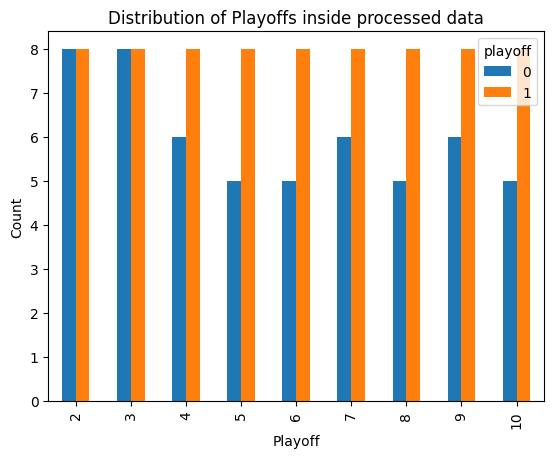

In [8]:
label_distribution = df.groupby(['year', 'playoff']).size().unstack()

label_distribution.plot(kind='bar')
plt.title('Distribution of Playoffs inside processed data')
plt.xlabel('Playoff')
plt.ylabel('Count')

plt.show()


### Correlation Matrix

In [9]:
tempdf = df.drop(columns='tmID', axis=1)
print(list(tempdf.columns))

['year', 'playoff', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'wr', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'dq', 'Award Count', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostDQ', 'PostthreeRatio', 'PostfgRatio', 'PostftRatio', 'ThreeRatio', 'fgRatio', 'ftRatio', 'coach_wr', 'coach_pwr']


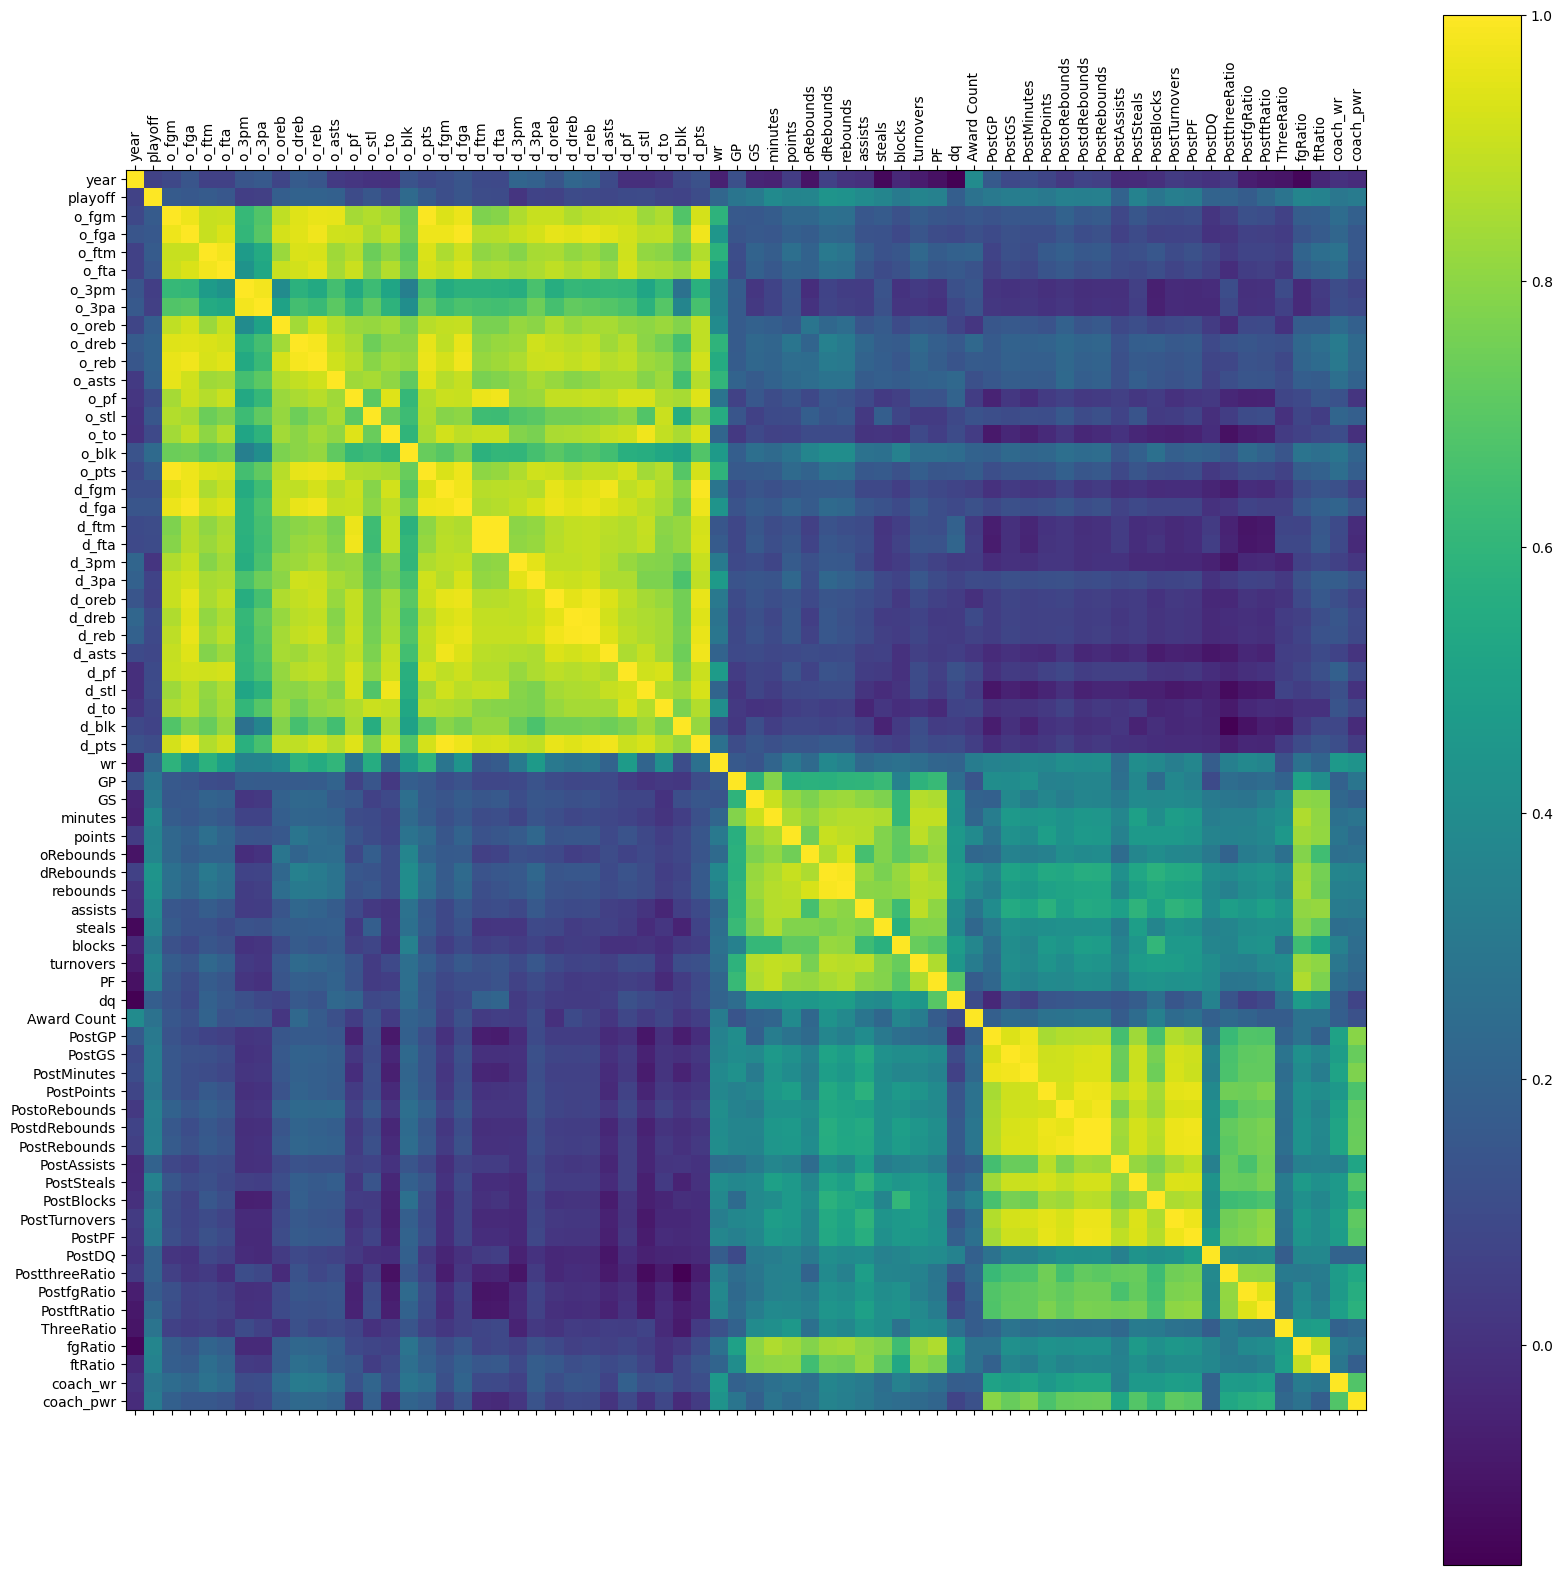

In [10]:
correlation = tempdf.corr()
plt.figure(figsize=(20, 20))
plt.matshow(correlation, fignum=1)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.colorbar()

plt.show()

### Pairplot

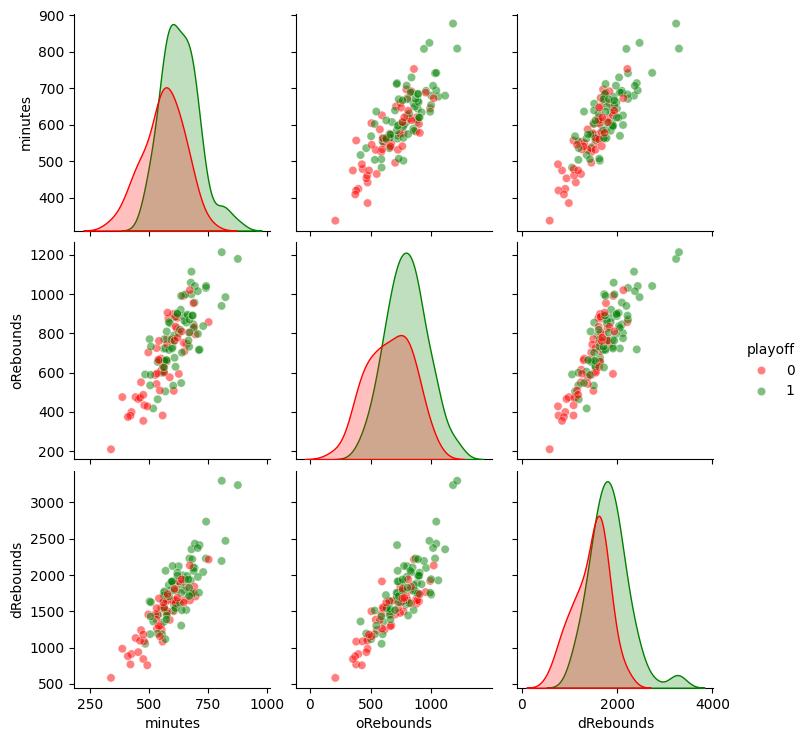

In [11]:
sample_size = df.__len__()

attributes = ["playoff", "minutes", "oRebounds", "dRebounds"]

sample = df.sample(sample_size)[attributes]

palette = {0: 'red', 1: 'green'}
sb.pairplot(sample, hue='playoff', palette=palette, plot_kws={'alpha': 0.5})

### Points / Playoff

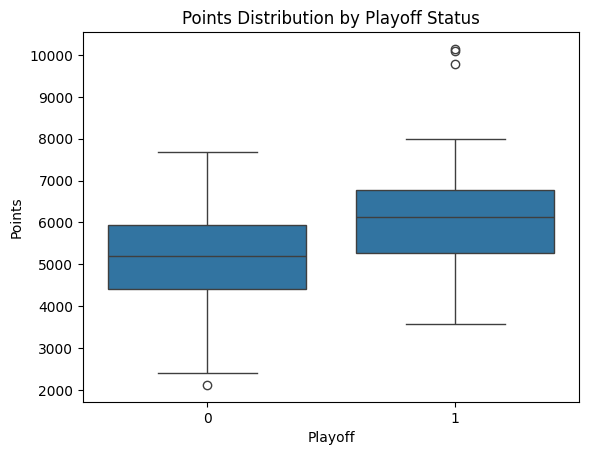

In [12]:
sb.boxplot(x='playoff', y='points', data=df)
plt.title('Points Distribution by Playoff Status')
plt.xlabel('Playoff')
plt.ylabel('Points')
plt.show()

### Find Outliers

In [13]:
### 

In [14]:
playoff_teams = df[df['playoff'] == 1]
non_playoff_teams = df[df['playoff'] == 0]
print(non_playoff_teams.__len__(), playoff_teams.__len__())

# how many teams didn't make it to the playoffs with > 6000 points
hp = df[(df['points'] > 6000) & (df['playoff'] == 0)]
print(hp[['year', 'tmID', 'points']])

# how many teams made it to the playoffs with < 5000 points
lp = df[(df['points'] < 5000) & (df['playoff'] == 1)]
print(lp[['year', 'tmID', 'points']])

54 72
     year tmID       points
21     10  CON  6433.011254
22      2  DET  6569.736735
59      2  MIN  6553.300765
65      8  MIN  6442.673463
67     10  MIN  7033.156560
70      4  NYL  7682.648990
77      2  ORL  6334.074567
83      6  PHO  6047.095482
86      9  PHO  7659.621770
88      2  POR  6106.463251
99      4  SAS  6980.792161
117     2  WAS  7630.188303
     year tmID       points
3       3  CHA  4569.733729
12      2  CLE  3821.461397
14      4  CLE  4655.664482
31      2  HOU  4491.567318
40      3  IND  4368.467581
57      2  MIA  4826.131793
72      6  NYL  4622.254395
74      8  NYL  3582.056680
75      9  NYL  4735.585512
96      8  SAC  4189.669522
97      9  SAC  4657.649293
107     3  SEA  3719.730531
112     8  SEA  4975.651883
118     3  WAS  4029.842687


In [15]:
import numpy as np
from scipy import stats

# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Calculate Z-scores
df_zscores = df[numeric_cols].apply(stats.zscore)

# Identify outliers where Z-score > 3 or Z-score < -3 in any column
outliers = df[(np.abs(df_zscores) > 3).any(axis=1)]

# Display outliers
print(outliers)

     year tmID  playoff       o_fgm        o_fga       o_ftm       o_fta  \
0       9  ATL        0    0.000000     0.000000    0.000000    0.000000   
8       7  CHI        0    0.000000     0.000000    0.000000    0.000000   
15      4  CON        1    0.000000     0.000000    0.000000    0.000000   
31      2  HOU        1  891.000000  1894.000000  521.000000  634.000000   
33      4  HOU        1  868.240400  1885.228850  506.975850  622.446375   
48      2  LAS        1  861.000000  1956.000000  545.000000  693.000000   
49      3  LAS        1  865.675000  1962.375000  536.840000  684.585000   
50      4  LAS        1  867.827625  1965.743125  531.668600  681.220275   
51      5  LAS        1  870.052277  1980.554959  532.121769  680.946552   
56     10  LAS        1  891.385957  2053.052889  525.141272  682.150178   
68      2  NYL        1  792.000000  1815.000000  429.000000  567.000000   
70      4  NYL        0  793.488775  1809.636075  419.301925  561.789075   
73      7  N

In [16]:
from sklearn.ensemble import IsolationForest

# Prepare data (drop non-numeric columns if necessary)
X = df[numeric_cols]

# Fit the model
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_forest.fit(X)

# Add the scores and predictions to the DataFrame
df['anomaly_score'] = iso_forest.decision_function(X)
df['outlier'] = iso_forest.predict(X)

# Outliers are labeled as -1
outliers = df[df['outlier'] == -1]

# Display outliers
print(outliers)

     year tmID  playoff       o_fgm        o_fga       o_ftm       o_fta  \
0       9  ATL        0    0.000000     0.000000    0.000000    0.000000   
1      10  ATL        1  895.000000  2258.000000  542.000000  725.000000   
8       7  CHI        0    0.000000     0.000000    0.000000    0.000000   
15      4  CON        1    0.000000     0.000000    0.000000    0.000000   
33      4  HOU        1  868.240400  1885.228850  506.975850  622.446375   
51      5  LAS        1  870.052277  1980.554959  532.121769  680.946552   
56     10  LAS        1  891.385957  2053.052889  525.141272  682.150178   
68      2  NYL        1  792.000000  1815.000000  429.000000  567.000000   
99      4  SAS        0    0.000000     0.000000    0.000000    0.000000   
105    10  SAS        1  819.575095  2067.799036  526.522019  703.604915   
115     2  UTA        1  858.000000  1896.000000  609.000000  790.000000   

          o_3pm       o_3pa      o_oreb  ...  PostthreeRatio  PostfgRatio  \
0      0.0

In [17]:
from sklearn.neighbors import LocalOutlierFactor

# Fit the model
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# Predict anomalies (-1 for outliers)
df['outlier'] = lof.fit_predict(X)

# Extract scores (negative scores are outliers)
df['anomaly_score'] = lof.negative_outlier_factor_

# Identify outliers
outliers = df[df['outlier'] == -1]

# Display outliers
print(outliers)

     year tmID  playoff       o_fgm        o_fga       o_ftm       o_fta  \
0       9  ATL        0    0.000000     0.000000    0.000000    0.000000   
8       7  CHI        0    0.000000     0.000000    0.000000    0.000000   
15      4  CON        1    0.000000     0.000000    0.000000    0.000000   
33      4  HOU        1  868.240400  1885.228850  506.975850  622.446375   
51      5  LAS        1  870.052277  1980.554959  532.121769  680.946552   
56     10  LAS        1  891.385957  2053.052889  525.141272  682.150178   
59      2  MIN        0  770.000000  1831.000000  449.000000  592.000000   
73      7  NYL        0  800.648833  1831.501307  419.904869  556.798290   
81      4  PHO        0  799.350100  1814.875850  497.286900  644.789650   
89      3  POR        0  758.620000  1833.355000  484.770000  689.775000   
99      4  SAS        0    0.000000     0.000000    0.000000    0.000000   
106     2  SEA        0  667.000000  1740.000000  379.000000  561.000000   

          o

### Pairplot for player position

        bioID pos  firstseason  lastseason  height  weight      college  \
0  abrossv01w   F            0           0    74.0     169  Connecticut   
1  abrossv01w   F            0           0    74.0     169  Connecticut   
2  abrossv01w   F            0           0    74.0     169  Connecticut   
3  abrossv01w   F            0           0    74.0     169  Connecticut   
4  abrossv01w   F            0           0    74.0     169  Connecticut   

  collegeOther   birthDate   deathDate  ... PostBlocks  PostTurnovers  PostPF  \
0          NaN  1980-07-09  0000-00-00  ...          0              0       0   
1          NaN  1980-07-09  0000-00-00  ...          0              0       0   
2          NaN  1980-07-09  0000-00-00  ...          1              8       8   
3          NaN  1980-07-09  0000-00-00  ...          2              3       7   
4          NaN  1980-07-09  0000-00-00  ...          0              0       0   

  PostfgAttempted PostfgMade  PostftAttempted  PostftMade  Pos

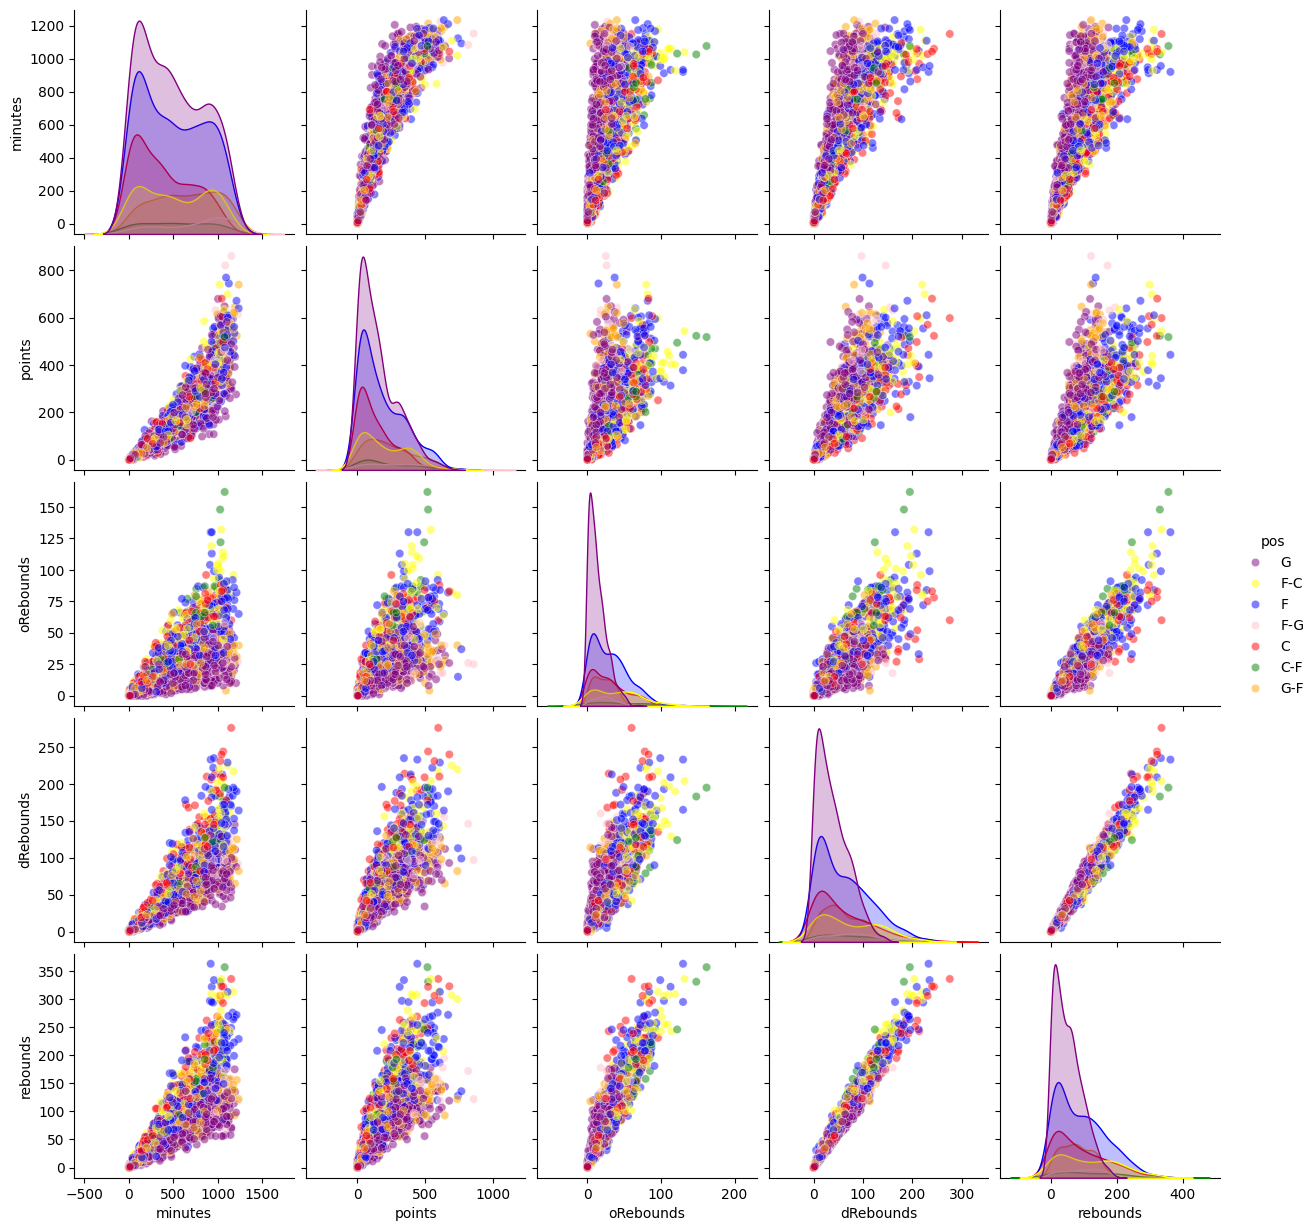

In [23]:
# Join players and player_teams
players = player_df.merge(pt_df, how='right', left_on='bioID', right_on='playerID')
print(players.head())

psample_size = players.__len__()

pattributes = [
        "pos","minutes","points","oRebounds","dRebounds",
        "rebounds", # Non Post stats
        ]
"""     
"GP","GS","assists","steals","blocks","turnovers","PF",
        "fgAttempted","fgMade","ftAttempted","ftMade","threeAttempted",
        "threeMade","dq",
        "PostGP","PostGS","PostMinutes","PostPoints","PostoRebounds",
        "PostdRebounds","PostRebounds","PostAssists","PostSteals",
        "PostBlocks","PostTurnovers","PostPF","PostfgAttempted",
        "PostfgMade","PostftAttempted","PostftMade",
        "PostthreeAttempted","PostthreeMade","PostDQ" # Post stats 
"""

psample = players.sample(psample_size)[pattributes]

ppalette = {"C": 'red', "C-F": 'green', "F": 'blue', "F-C": 'yellow', "G": 'purple', "G-F": 'orange', "F-G": 'pink'}

sb.pairplot(psample, hue='pos', palette=ppalette, plot_kws={'alpha': 0.5})

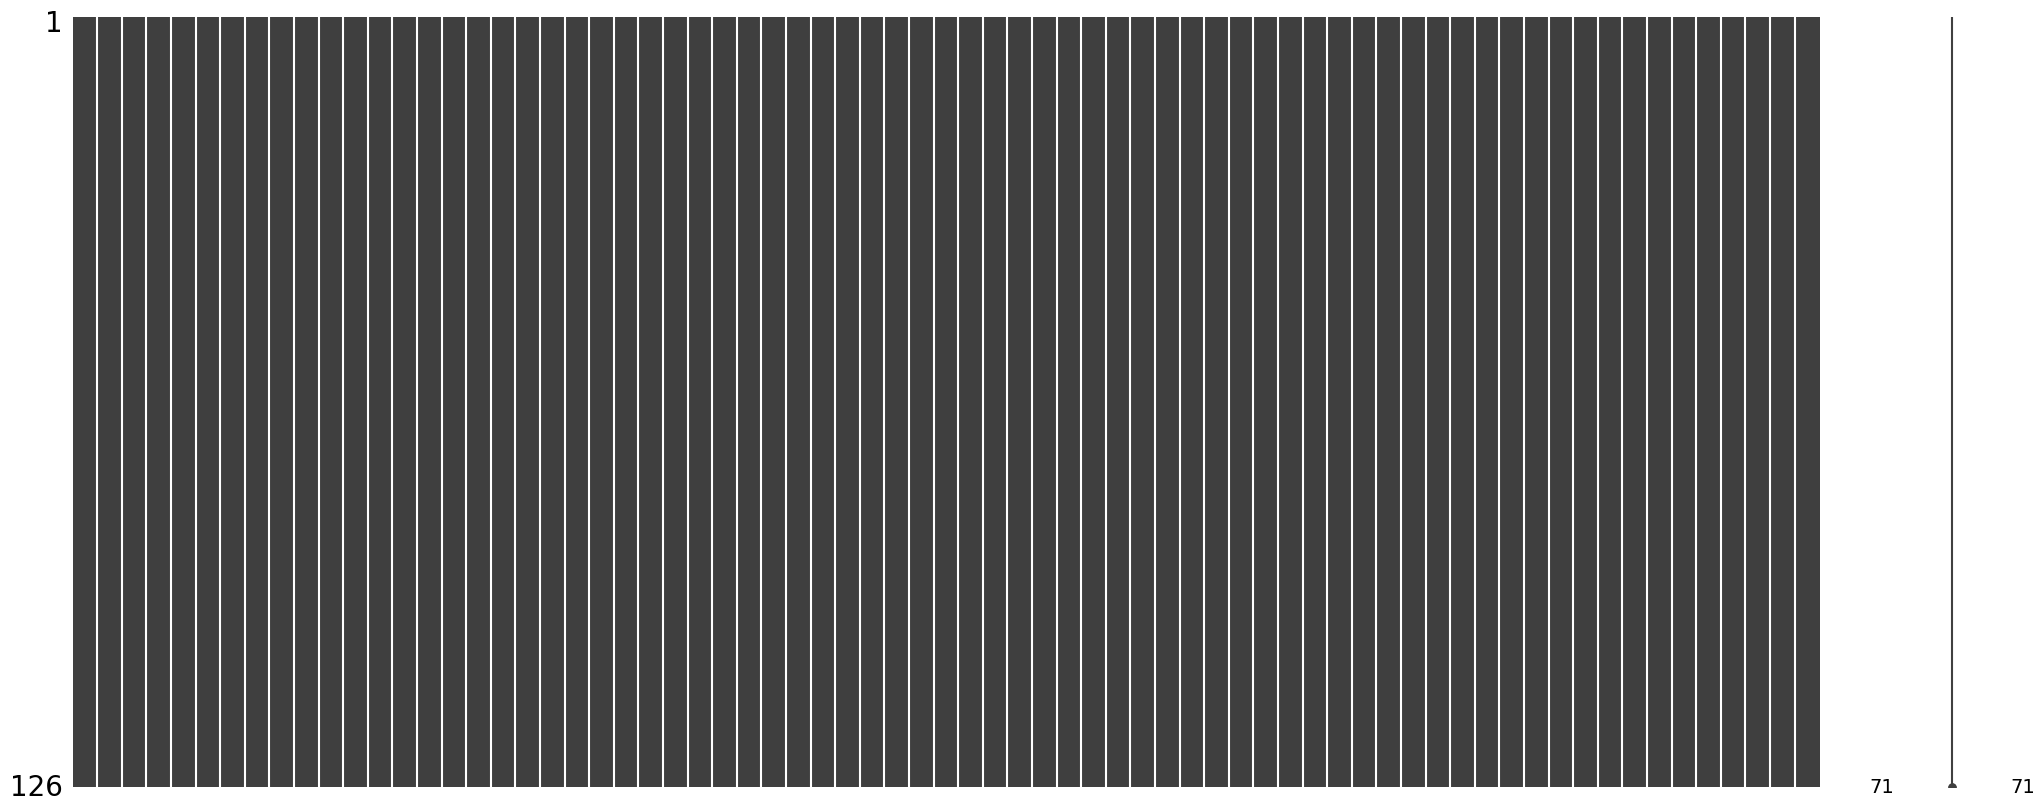

In [24]:
import missingno as msno

# Display missing values
msno.matrix(df)
plt.show()